The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

### In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [1]:
# %matplotlib inline will lead to static images of your plot embedded in the notebook
%matplotlib inline

#starts python imports
import math ,time ,random,datetime
import numpy as np
import pandas as pd

# To visualize
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
#machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dataset = pd.read_csv('Data/train.csv')
test_dataset = pd.read_csv('Data/test.csv')
gender_submission_dataset = pd.read_csv('Data/gender_submission.csv')
train_dataset.head(100)
## head() has 5 as a default parameter

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S


<AxesSubplot:ylabel='Frequency'>

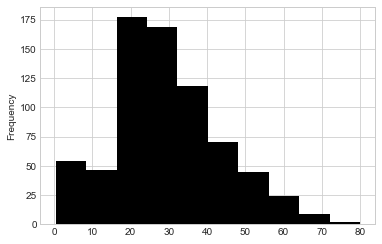

In [3]:
# hist is use to create historgram for more info please refer this(https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/)
train_dataset.Age.plot.hist(color = 'k')

In [4]:
test_dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<AxesSubplot:ylabel='Frequency'>

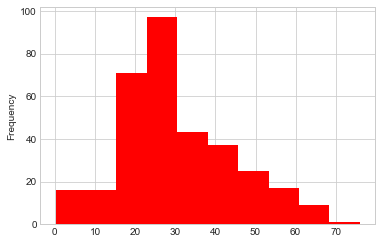

In [5]:
test_dataset.Age.plot.hist(color = 'red')

In [6]:
gender_submission_dataset.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<AxesSubplot:ylabel='Frequency'>

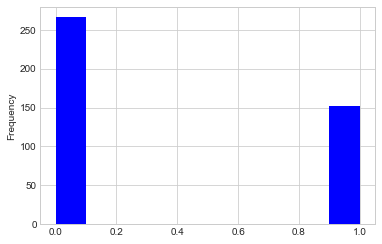

In [7]:
gender_submission_dataset.Survived.plot.hist(color = 'Blue')

#### We have sucessfully imporetd the data 

### Data Descriptions
#####  Survival: 0 = No , 1 = Yes
##### pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd
##### sibsp: number of siblings/spouses aboard the Titanic
##### parch: number of parents/children aboard the Titanic
##### embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton
##### fare: Passenger fare

In [8]:
# describe() to get a statical summary of a data frame
# info() to get the information about the data frame
test_dataset.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [9]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### What are the missing values in our data frame
These are rows which are missing a value or have NaN instead of something like the rest of the column.

<AxesSubplot:>

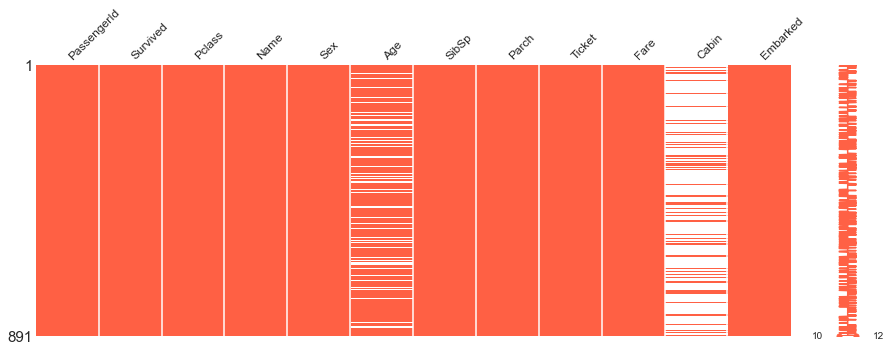

In [10]:
# To check missing value in our train data set
#(https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/) refer for more info
#(https://coderzcolumn.com/tutorials/data-science/missingno-visualize-missing-data-in-python)
msno.matrix(train_dataset,fontsize = 12,figsize =(15,5),color=(1, 0.38, 0.27))

Now we can clearly see some missing values here. Especially in the cabin column.
It's important to visualise missing values early so you know where the major holes are in your dataset.
Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

#### There is a another Alternative method through which we can see the missing values


In [11]:
# isnull() will return true if data is not missing and it will return false if the data is missing
train_dataset.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
# This is another alternative way to find missing data values.It will give the number of count of missing values.
train_dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As we can that cabin has 687 null values and cabin consist total 891 values, that's mean cabin has 204 non-null values.
we can verify it by using pandas function " info() ".

#### Now we are analysing our data , So let's create two dataframes

In [13]:
#for discretised continuous variables
df_bin = pd.DataFrame() 
# For continuous variables
df_con = pd.DataFrame()

#### What datatypes are in the dataframe?
As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.
However, as we dig deeper, we might find features which are numerical may actually be categorical.
The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.
Ideally, all the features will be encoded into a numerical value of some kind.
#### Why do we care?
Data types are one of those things that you don’t tend to care about until you get an error or some unexpected results. It is also one of the first things you should check once you load a new data into pandas for further analysis.

#### We can check the different data type in our dataset using " dtypes" function

In [14]:
train_dataset.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

0    549
1    342
Name: Survived, dtype: int64


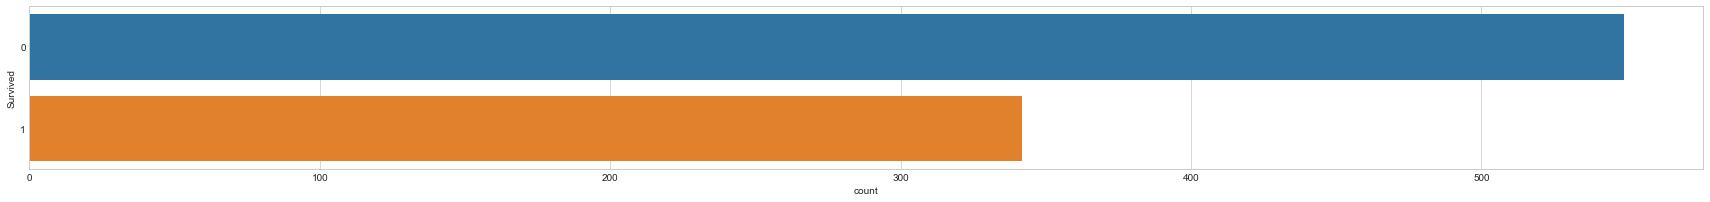

In [15]:
# How many people survived?(https://seaborn.pydata.org/generated/seaborn.countplot.html)
fig = plt.figure(figsize=(30,3))
sns.countplot(y='Survived', data=train_dataset);
print(train_dataset.Survived.value_counts())

In [16]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train_dataset['Survived']
df_con['Survived'] = train_dataset['Survived']

In [17]:
df_bin.head(25)

,Survived
0,0
1,1
2,1
3,1
4,0
5,0
6,0
7,0
8,1
9,1


In [18]:
df_con.head(25)

,Survived
0,0
1,1
2,1
3,1
4,0
5,0
6,0
7,0
8,1
9,1


### Feature : Pclass
Description: The ticket class of the passenger.
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

### Let's plot the distribution
We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.
For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

 

<AxesSubplot:xlabel='Pclass', ylabel='Density'>

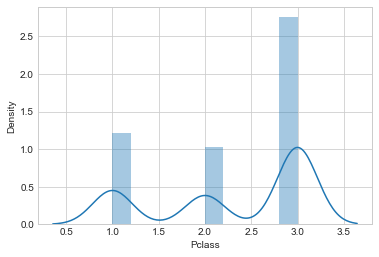

In [19]:
sns.distplot(train_dataset.Pclass)

In [20]:
# Now let's check how many missing values does Pclass have?
train_dataset.Pclass.isnull().sum()

0

So we can see that a Pclass doesn't have any missing values.Let's add it to our sub dataframes

In [21]:
df_bin["Pclass"] = train_dataset['Pclass']
df_con['Pclass'] = train_dataset['Pclass']

In [22]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [23]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


### Feature : Name
Description : The name of passanger

In [24]:
# How many different names are there?
train_dataset.Name.value_counts()

Christy, Miss. Julie Rachel     1
Burke, Mr. Jeremiah             1
Betros, Mr. Tannous             1
Keefe, Mr. Arthur               1
Scanlan, Mr. James              1
                               ..
Johnston, Mr. Andrew G          1
Greenberg, Mr. Samuel           1
Moran, Mr. Daniel J             1
Eitemiller, Mr. George Floyd    1
Asim, Mr. Adola                 1
Name: Name, Length: 891, dtype: int64

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.
###### Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

#### Feature : Sex
Description: The sex of the passenger (male or female)

0    549
1    342
Name: Survived, dtype: int64


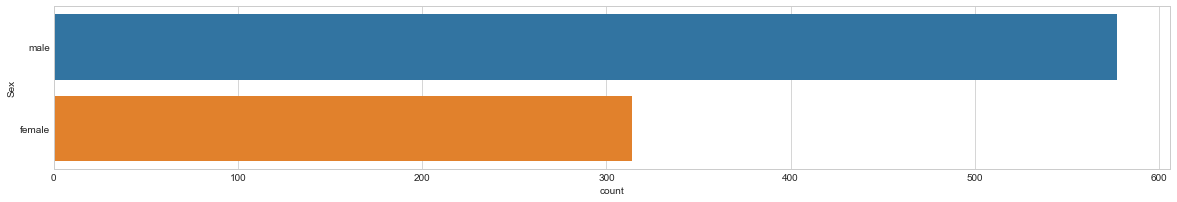

In [25]:
#Let's see the distribution of sex
fig = plt.figure(figsize=(20,3))
sns.countplot(y='Sex', data=train_dataset);
print(train_dataset.Survived.value_counts())

In [26]:
# Are there any misssing values in Sex column?
train_dataset.Sex.isnull().sum()

0

So,As we see that Sex column also have no missing value.Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [27]:
# add Sex to the subset dataframes
df_bin['Sex'] = train_dataset['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train_dataset['Sex']

In [28]:
df_bin.head(10)

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0
5,0,3,0
6,0,1,0
7,0,3,0
8,1,3,1
9,1,2,1


In [29]:
df_con.head()

,Survived,Pclass,Sex
0,0,3,male
1,1,1,female
2,1,3,female
3,1,1,female
4,0,3,male


#### Function to create count and distribution visualisations

In [30]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"color": "k" , "label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"color": "red","label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"color": "k","label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"color": "red","label": "Did not survive"});

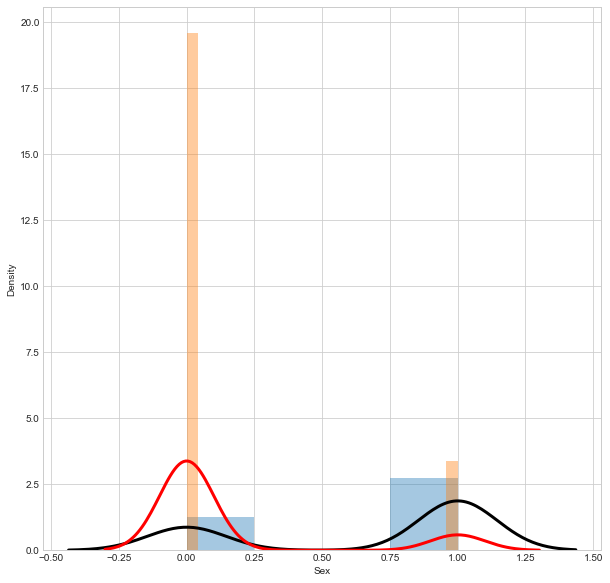

In [31]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={"color": "k", "lw": 3, 'label': "Survived"});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'],  kde_kws={"color": "red", "lw": 3, 'label': "Do not Survive"});

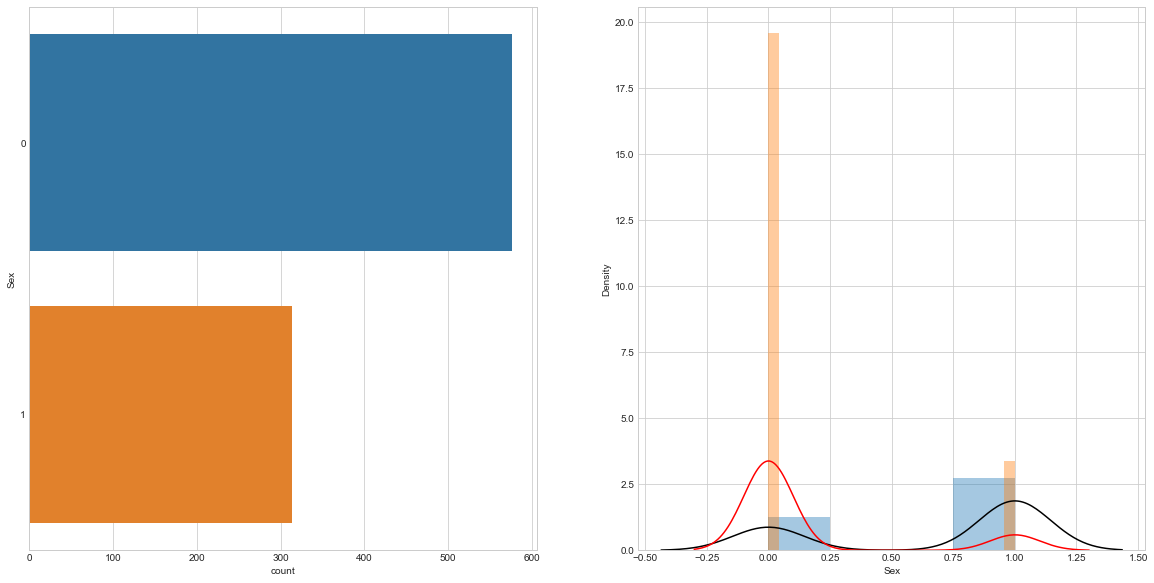

In [32]:
# Visualise the counts of Sex and the distribution of the values
# against Survived
plot_count_dist(df_bin, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='Sex', 
                figsize=(20, 10))

Not many people survived. But of those who did, more were female.

#### Feature: Age
Description: The age of the passenger.

In [33]:
# How many missing values does age have?
train_dataset.Age.isnull().sum()

177

In [34]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
#df_bin['Age'] = pd.cut(train_dataset['Age'], 10) # bucketed/binned into different categories
#df_con['Age'] = train_dataset['Age'] # non-bucketed

In [35]:
#df_bin.head(10)

In [36]:
#df_con.head(10)

#### Feature: SibSp
Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [37]:
# How many missing values does SibSp have?
train_dataset.SibSp.isnull().sum()

0

So, SibSp have no missing values.


In [38]:
# What values are there?
train_dataset.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

This means 608 passanger has no siblings aboard the Titanic,209 passngers have 1 and so on.

##### Let's add SibSp to our subset dataframes and view the distributions.

In [39]:
df_bin['SibSp'] = train_dataset["SibSp"]
df_con['SibSp'] = train_dataset["SibSp"]

In [40]:
df_bin.head()

,Survived,Pclass,Sex,SibSp
0,0,3,0,1
1,1,1,1,1
2,1,3,1,0
3,1,1,1,1
4,0,3,0,0


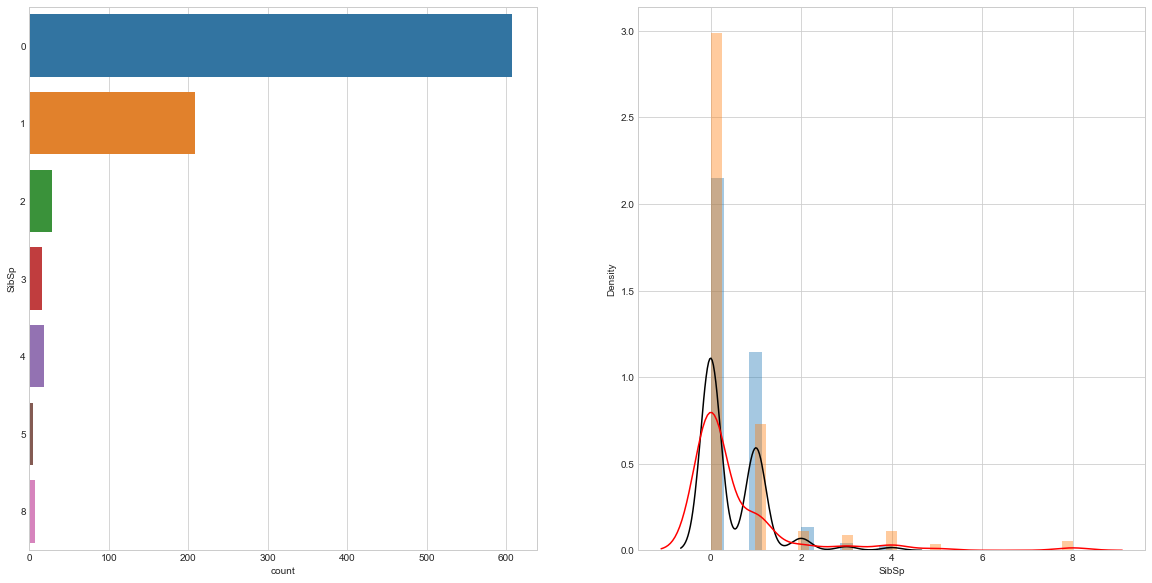

In [41]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train_dataset, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

This graphs tells us that passanger who has siblings aboard the Titanic,survived mostly.

#### Feature: Parch
Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [42]:
# How many missing values does Parch have?
train_dataset.Parch.isnull().sum()

0

So, Parch have no missing values.

In [43]:
# What values are there?
train_dataset.Parch.value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [44]:
# Add Parch to subset dataframes
df_bin['Parch'] = train_dataset['Parch']
df_con['Parch'] = train_dataset['Parch']

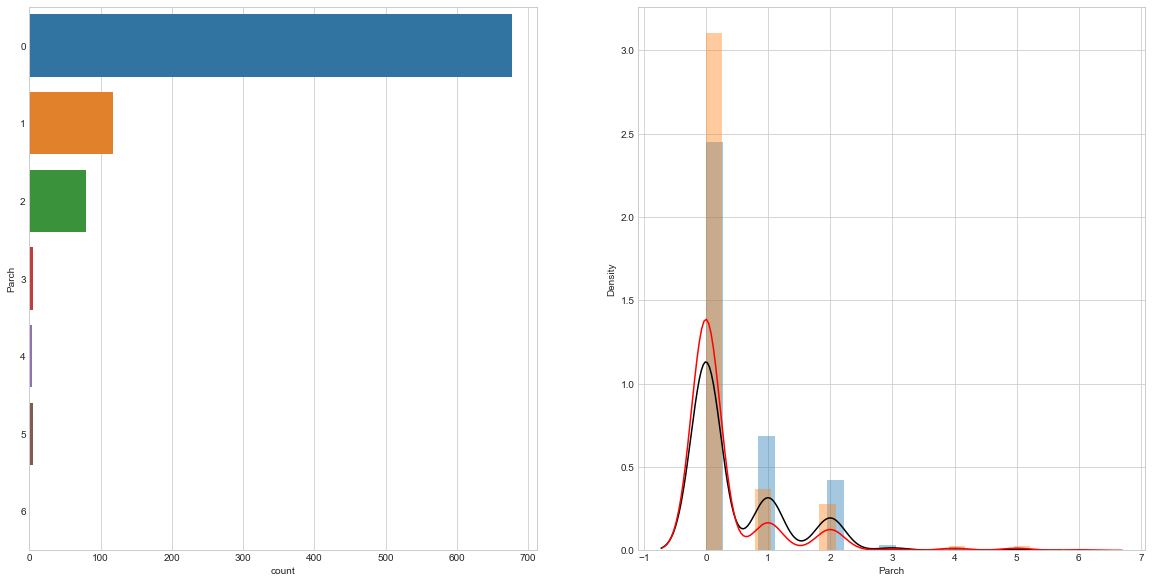

In [45]:
# Visualise the counts of Sex and the distribution of the values
# against Survived
plot_count_dist(train_dataset, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

#### Feature: Ticket
Description: The ticket number of the boarding passenger

In [46]:
# How many missing values does Parch have?
train_dataset.Parch.isnull().sum()

0

So, Parch have no missing values.


In [47]:
# How many kinds of ticket are there?
train_dataset.Ticket.value_counts()

CA. 2343    7
347082      7
1601        7
347088      6
3101295     6
           ..
19952       1
13509       1
347068      1
113051      1
350046      1
Name: Ticket, Length: 681, dtype: int64

We can show them also;


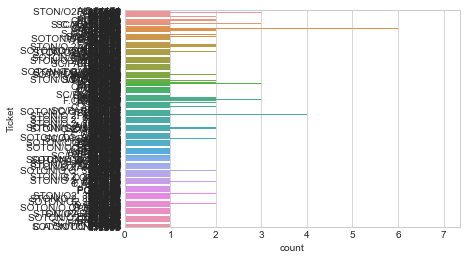

In [48]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train_dataset);

In [49]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train_dataset.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use Ticket in our subset dataframes.

There may be some way to reduce this down.


#### Feature: Fare
Description: How much the ticket cost.

In [50]:
# How many missing values does Fare have?
train_dataset.Fare.isnull().sum()


0

So, Fare have no missing values.

In [51]:
train_dataset.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

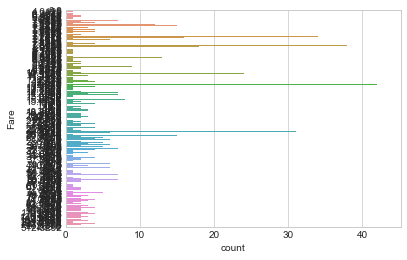

In [52]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train_dataset);

In [53]:
# What kind of variable is Fare?
train_dataset.Fare.dtype

dtype('float64')

In [54]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train_dataset.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [55]:
# Add Fare to sub dataframes
df_con['Fare'] = train_dataset['Fare'] 
df_bin['Fare'] = pd.cut(train_dataset['Fare'], bins=5) # discretised 

In [56]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

So, We have 5 categories. So definitely every Fare lies in one of those categories.

In [57]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


In [58]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


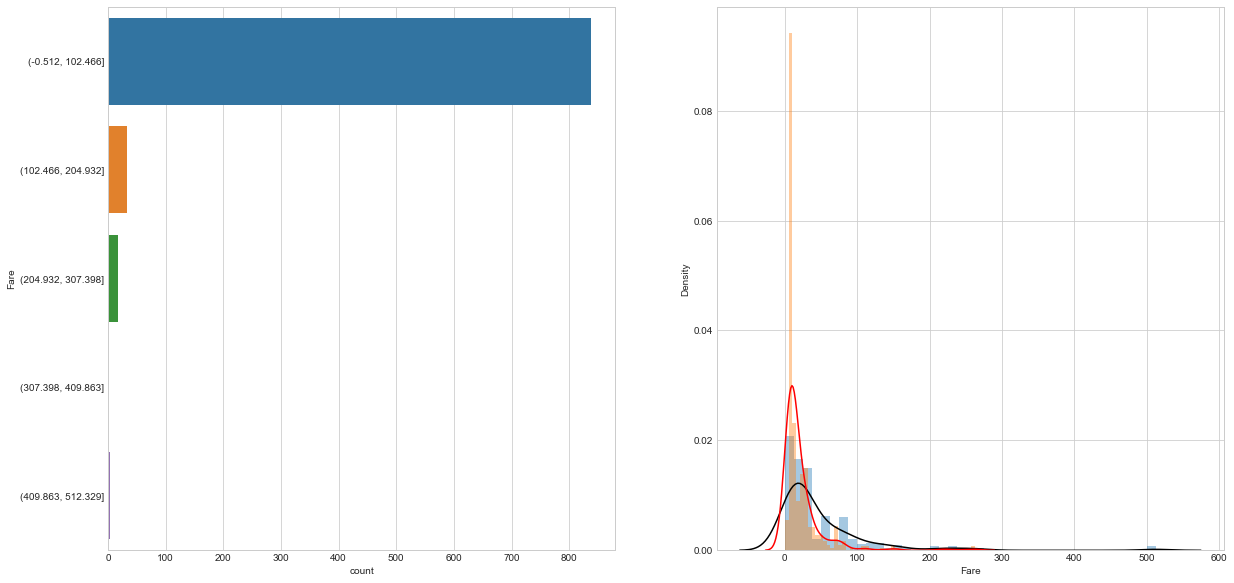

In [59]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train_dataset,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

#### Feature: Cabin
Description: The cabin number where the passenger was staying.

In [60]:
# How many missing values does Cabin have?
train_dataset.Cabin.isnull().sum()

687

In [61]:
# What do the Cabin values look like?
train_dataset.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
D              3
F2             3
              ..
B80            1
C82            1
C104           1
C95            1
B78            1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

#### Feature: Embarked
Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [62]:
# How many missing values does Embarked have?
train_dataset.Embarked.isnull().sum()

2

In [63]:
# What kind of values are in Embarked?
train_dataset.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

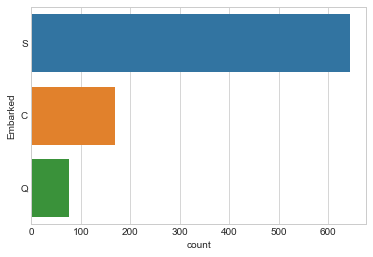

In [64]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train_dataset);

One option is to drop the two rows which don't have an Embarked value.
Another option would be to randomly assign a value of C, Q or S to each row.
What are the pros and cons of each?

For now, we will remove those rows.

In [65]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train_dataset['Embarked']
df_con['Embarked'] = train_dataset['Embarked']

In [66]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

### Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.

In [67]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [68]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [69]:
# One-hot encode binned variables
#This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived') ## We don't need to do encode of Survived feature
df_bin_enc = pd.get_dummies(df_bin, columns = one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [70]:
df_con.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S
5,0,3,male,0,0,8.4583,Q
6,0,1,male,0,0,51.8625,S
7,0,3,male,3,1,21.0750,S
8,1,3,female,0,2,11.1333,S
9,1,2,female,1,0,30.0708,C


In [71]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [72]:
df_sex_one_hot.head()

,sex_female,sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [73]:
# It should be 3 columns
df_plcass_one_hot.head()

,pclass_1,pclass_2,pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [74]:
df_embarked_one_hot.head()

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [75]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [76]:
df_con_enc.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


### Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [77]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [78]:
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [79]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [80]:
# Shape of the data (without labels)
X_train.shape

(889, 11)

#### X_train has 11 columns because we've droped on columns 'Survived' and add it to y_train

In [81]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [82]:
y_train.shape

(889,)

In [83]:
y_train.head(255)

0      0
1      1
2      1
3      1
4      0
      ..
251    0
252    0
253    0
254    0
255    1
Name: Survived, Length: 255, dtype: int64

Now, y-train is a vector

#### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [84]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)  #(https://www.w3schools.com/python/ref_func_round.asp)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [85]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:03.301927


### K-Nearest Neighbours

In [86]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.502239


### Gaussian Naive Bayes

In [87]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.139927


### Linear Support Vector Machines (SVC)

In [88]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.07
Accuracy CV 10-Fold: 75.82
Running Time: 0:00:00.444400


### Stochastic Gradient Descent


In [89]:
#Stochastic Gradient Descent
start_time  = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time  = (time.time() - start_time)
print("Accuracy:" ,acc_sgd)
print("Accuracy CV 10-Fold:" ,acc_cv_sgd)
print("Running Time:" ,datetime.timedelta(seconds=sgd_time))

Accuracy: 41.06
Accuracy CV 10-Fold: 70.19
Running Time: 0:00:00.278087


### Decision Tree Classifier

In [90]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.54
Running Time: 0:00:00.312411


### Gradient Boost Trees

In [91]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:00.712501


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the CatBoost docs.

In [92]:
# View the data for the CatBoost model
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [93]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [94]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

This means Catboost has picked up that all variables except Fare can be treated as categorical.

In [95]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [96]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [97]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 2.79s	remaining: 46m 30s
1:	learn: 0.6809444	total: 2.81s	remaining: 23m 24s
2:	learn: 0.6751692	total: 2.83s	remaining: 15m 41s
3:	learn: 0.6689060	total: 2.85s	remaining: 11m 49s
4:	learn: 0.6632144	total: 2.87s	remaining: 9m 30s
5:	learn: 0.6576488	total: 2.89s	remaining: 7m 58s
6:	learn: 0.6544441	total: 2.9s	remaining: 6m 50s
7:	learn: 0.6490635	total: 2.92s	remaining: 6m 1s
8:	learn: 0.6443241	total: 2.94s	remaining: 5m 23s
9:	learn: 0.6395935	total: 2.97s	remaining: 4m 53s
10:	learn: 0.6345186	total: 2.99s	remaining: 4m 28s
11:	learn: 0.6305316	total: 3.02s	remaining: 4m 8s
12:	learn: 0.6275610	total: 3.03s	remaining: 3m 50s
13:	learn: 0.6225020	total: 3.06s	remaining: 3m 35s
14:	learn: 0.6179503	total: 3.08s	remaining: 3m 22s
15:	learn: 0.6140480	total: 3.1s	remaining: 3m 10s
16:	learn: 0.6100034	total: 3.12s	remaining: 3m
17:	learn: 0.6049646	total: 3.15s	remaining: 2m 51s
18:	learn: 0.6025760	total: 3.16s	remaining: 2m 

159:	learn: 0.4245472	total: 6.44s	remaining: 33.8s
160:	learn: 0.4243067	total: 6.47s	remaining: 33.7s
161:	learn: 0.4240101	total: 6.51s	remaining: 33.7s
162:	learn: 0.4236345	total: 6.54s	remaining: 33.6s
163:	learn: 0.4234396	total: 6.58s	remaining: 33.5s
164:	learn: 0.4228926	total: 6.6s	remaining: 33.4s
165:	learn: 0.4227463	total: 6.63s	remaining: 33.3s
166:	learn: 0.4226186	total: 6.65s	remaining: 33.2s
167:	learn: 0.4222141	total: 6.67s	remaining: 33s
168:	learn: 0.4219366	total: 6.69s	remaining: 32.9s
169:	learn: 0.4216245	total: 6.72s	remaining: 32.8s
170:	learn: 0.4213900	total: 6.74s	remaining: 32.7s
171:	learn: 0.4210836	total: 6.77s	remaining: 32.6s
172:	learn: 0.4208199	total: 6.8s	remaining: 32.5s
173:	learn: 0.4206421	total: 6.82s	remaining: 32.4s
174:	learn: 0.4201114	total: 6.84s	remaining: 32.3s
175:	learn: 0.4198212	total: 6.87s	remaining: 32.2s
176:	learn: 0.4195834	total: 6.89s	remaining: 32s
177:	learn: 0.4195685	total: 6.9s	remaining: 31.9s
178:	learn: 0.41948

326:	learn: 0.3929436	total: 10.2s	remaining: 21s
327:	learn: 0.3928210	total: 10.2s	remaining: 21s
328:	learn: 0.3926321	total: 10.3s	remaining: 20.9s
329:	learn: 0.3926315	total: 10.3s	remaining: 20.9s
330:	learn: 0.3925085	total: 10.3s	remaining: 20.8s
331:	learn: 0.3921820	total: 10.3s	remaining: 20.8s
332:	learn: 0.3920570	total: 10.4s	remaining: 20.8s
333:	learn: 0.3918707	total: 10.4s	remaining: 20.7s
334:	learn: 0.3917635	total: 10.4s	remaining: 20.7s
335:	learn: 0.3916127	total: 10.5s	remaining: 20.7s
336:	learn: 0.3914735	total: 10.5s	remaining: 20.6s
337:	learn: 0.3914486	total: 10.5s	remaining: 20.6s
338:	learn: 0.3912764	total: 10.5s	remaining: 20.5s
339:	learn: 0.3911365	total: 10.6s	remaining: 20.5s
340:	learn: 0.3910828	total: 10.6s	remaining: 20.5s
341:	learn: 0.3910413	total: 10.6s	remaining: 20.4s
342:	learn: 0.3910351	total: 10.6s	remaining: 20.4s
343:	learn: 0.3908388	total: 10.7s	remaining: 20.3s
344:	learn: 0.3907468	total: 10.7s	remaining: 20.3s
345:	learn: 0.39

491:	learn: 0.3774361	total: 14s	remaining: 14.4s
492:	learn: 0.3772670	total: 14s	remaining: 14.4s
493:	learn: 0.3771396	total: 14s	remaining: 14.4s
494:	learn: 0.3771236	total: 14.1s	remaining: 14.3s
495:	learn: 0.3770363	total: 14.1s	remaining: 14.3s
496:	learn: 0.3769634	total: 14.1s	remaining: 14.3s
497:	learn: 0.3769625	total: 14.1s	remaining: 14.2s
498:	learn: 0.3768613	total: 14.1s	remaining: 14.2s
499:	learn: 0.3768611	total: 14.1s	remaining: 14.1s
500:	learn: 0.3768153	total: 14.2s	remaining: 14.1s
501:	learn: 0.3767849	total: 14.2s	remaining: 14.1s
502:	learn: 0.3765500	total: 14.2s	remaining: 14s
503:	learn: 0.3763980	total: 14.2s	remaining: 14s
504:	learn: 0.3763692	total: 14.3s	remaining: 14s
505:	learn: 0.3763085	total: 14.3s	remaining: 13.9s
506:	learn: 0.3761631	total: 14.3s	remaining: 13.9s
507:	learn: 0.3760934	total: 14.3s	remaining: 13.9s
508:	learn: 0.3760498	total: 14.4s	remaining: 13.9s
509:	learn: 0.3760150	total: 14.4s	remaining: 13.8s
510:	learn: 0.3759970	to

652:	learn: 0.3644740	total: 18s	remaining: 9.58s
653:	learn: 0.3644317	total: 18.1s	remaining: 9.55s
654:	learn: 0.3644178	total: 18.1s	remaining: 9.51s
655:	learn: 0.3642661	total: 18.1s	remaining: 9.48s
656:	learn: 0.3642146	total: 18.1s	remaining: 9.45s
657:	learn: 0.3642143	total: 18.1s	remaining: 9.42s
658:	learn: 0.3641970	total: 18.1s	remaining: 9.39s
659:	learn: 0.3641835	total: 18.2s	remaining: 9.35s
660:	learn: 0.3641783	total: 18.2s	remaining: 9.32s
661:	learn: 0.3640790	total: 18.2s	remaining: 9.3s
662:	learn: 0.3640602	total: 18.2s	remaining: 9.27s
663:	learn: 0.3639463	total: 18.3s	remaining: 9.24s
664:	learn: 0.3639302	total: 18.3s	remaining: 9.21s
665:	learn: 0.3638903	total: 18.3s	remaining: 9.18s
666:	learn: 0.3637239	total: 18.3s	remaining: 9.15s
667:	learn: 0.3635881	total: 18.3s	remaining: 9.12s
668:	learn: 0.3634772	total: 18.4s	remaining: 9.09s
669:	learn: 0.3634068	total: 18.4s	remaining: 9.06s
670:	learn: 0.3633759	total: 18.4s	remaining: 9.03s
671:	learn: 0.3

820:	learn: 0.3532730	total: 21.8s	remaining: 4.75s
821:	learn: 0.3531556	total: 21.8s	remaining: 4.72s
822:	learn: 0.3531526	total: 21.9s	remaining: 4.71s
823:	learn: 0.3530893	total: 21.9s	remaining: 4.68s
824:	learn: 0.3528000	total: 21.9s	remaining: 4.65s
825:	learn: 0.3527557	total: 22s	remaining: 4.63s
826:	learn: 0.3527494	total: 22s	remaining: 4.6s
827:	learn: 0.3527097	total: 22s	remaining: 4.57s
828:	learn: 0.3525818	total: 22s	remaining: 4.54s
829:	learn: 0.3525719	total: 22.1s	remaining: 4.52s
830:	learn: 0.3523327	total: 22.1s	remaining: 4.49s
831:	learn: 0.3523023	total: 22.1s	remaining: 4.46s
832:	learn: 0.3522949	total: 22.1s	remaining: 4.43s
833:	learn: 0.3521358	total: 22.1s	remaining: 4.4s
834:	learn: 0.3521053	total: 22.2s	remaining: 4.38s
835:	learn: 0.3520985	total: 22.2s	remaining: 4.35s
836:	learn: 0.3520746	total: 22.2s	remaining: 4.32s
837:	learn: 0.3519963	total: 22.2s	remaining: 4.3s
838:	learn: 0.3519587	total: 22.2s	remaining: 4.27s
839:	learn: 0.3518946	t

985:	learn: 0.3407755	total: 25.8s	remaining: 367ms
986:	learn: 0.3405983	total: 25.9s	remaining: 341ms
987:	learn: 0.3404887	total: 25.9s	remaining: 314ms
988:	learn: 0.3404766	total: 25.9s	remaining: 288ms
989:	learn: 0.3404401	total: 25.9s	remaining: 262ms
990:	learn: 0.3403797	total: 25.9s	remaining: 236ms
991:	learn: 0.3403515	total: 26s	remaining: 209ms
992:	learn: 0.3402624	total: 26s	remaining: 183ms
993:	learn: 0.3402175	total: 26s	remaining: 157ms
994:	learn: 0.3399939	total: 26.1s	remaining: 131ms
995:	learn: 0.3399342	total: 26.2s	remaining: 105ms
996:	learn: 0.3398669	total: 26.2s	remaining: 78.8ms
997:	learn: 0.3398219	total: 26.2s	remaining: 52.5ms
998:	learn: 0.3397748	total: 26.3s	remaining: 26.3ms
999:	learn: 0.3396214	total: 26.3s	remaining: 0us


#### Perform CatBoost cross-validation

In [98]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)
11:	learn: 0.5447302	test: 0.5517930	best: 0.5517930 (11)
12:	learn: 0.5377424	test: 0.5449873	best: 0.5449873 (12)
13:	learn: 0.5305336	test: 0.5382423	best: 0.5382423 (13)
14:	learn: 0.5241296	test: 0.5323280	best: 0.5323280 (14)
15:	learn: 0.5171284	test: 0.5265741	best: 0.5265741 (15)
16:	learn: 0.5113308	test: 0.5214578	best: 0.5214578 (16)
17:	learn: 0.5063945	test: 0.51688

143:	learn: 0.3777646	test: 0.4376841	best: 0.4375885 (133)
144:	learn: 0.3775321	test: 0.4378089	best: 0.4375885 (133)
145:	learn: 0.3772125	test: 0.4377624	best: 0.4375885 (133)
146:	learn: 0.3769816	test: 0.4376400	best: 0.4375885 (133)
147:	learn: 0.3767073	test: 0.4376571	best: 0.4375885 (133)
148:	learn: 0.3765399	test: 0.4376666	best: 0.4375885 (133)
149:	learn: 0.3762756	test: 0.4376520	best: 0.4375885 (133)
150:	learn: 0.3761288	test: 0.4377161	best: 0.4375885 (133)
151:	learn: 0.3759425	test: 0.4377006	best: 0.4375885 (133)
152:	learn: 0.3756349	test: 0.4378041	best: 0.4375885 (133)
153:	learn: 0.3754100	test: 0.4378911	best: 0.4375885 (133)
154:	learn: 0.3751414	test: 0.4379486	best: 0.4375885 (133)
155:	learn: 0.3748791	test: 0.4380754	best: 0.4375885 (133)
156:	learn: 0.3746241	test: 0.4381365	best: 0.4375885 (133)
157:	learn: 0.3743435	test: 0.4381316	best: 0.4375885 (133)
158:	learn: 0.3739097	test: 0.4381786	best: 0.4375885 (133)
159:	learn: 0.3736041	test: 0.4381051	be

299:	learn: 0.3388870	test: 0.4378542	best: 0.4375885 (133)
300:	learn: 0.3386254	test: 0.4377301	best: 0.4375885 (133)
301:	learn: 0.3384212	test: 0.4378290	best: 0.4375885 (133)
302:	learn: 0.3381298	test: 0.4377625	best: 0.4375885 (133)
303:	learn: 0.3378125	test: 0.4376488	best: 0.4375885 (133)
304:	learn: 0.3375607	test: 0.4376942	best: 0.4375885 (133)
305:	learn: 0.3373273	test: 0.4377882	best: 0.4375885 (133)
306:	learn: 0.3370584	test: 0.4379255	best: 0.4375885 (133)
307:	learn: 0.3368230	test: 0.4378568	best: 0.4375885 (133)
308:	learn: 0.3365431	test: 0.4377564	best: 0.4375885 (133)
309:	learn: 0.3363557	test: 0.4377360	best: 0.4375885 (133)
310:	learn: 0.3362263	test: 0.4376479	best: 0.4375885 (133)
311:	learn: 0.3360123	test: 0.4377658	best: 0.4375885 (133)
312:	learn: 0.3357681	test: 0.4377828	best: 0.4375885 (133)
313:	learn: 0.3355690	test: 0.4378422	best: 0.4375885 (133)	total: 1m 56s	remaining: 4m 13s
314:	learn: 0.3353338	test: 0.4378656	best: 0.4375885 (133)
315:	lea

436:	learn: 0.3050698	test: 0.4335151	best: 0.4333669 (432)
437:	learn: 0.3047879	test: 0.4334492	best: 0.4333669 (432)
438:	learn: 0.3046007	test: 0.4333917	best: 0.4333669 (432)
439:	learn: 0.3044894	test: 0.4334150	best: 0.4333669 (432)
440:	learn: 0.3043265	test: 0.4335227	best: 0.4333669 (432)
441:	learn: 0.3041210	test: 0.4334722	best: 0.4333669 (432)
442:	learn: 0.3039089	test: 0.4333488	best: 0.4333488 (442)
443:	learn: 0.3037218	test: 0.4334071	best: 0.4333488 (442)
444:	learn: 0.3034592	test: 0.4334150	best: 0.4333488 (442)
445:	learn: 0.3032770	test: 0.4333923	best: 0.4333488 (442)
446:	learn: 0.3031330	test: 0.4332800	best: 0.4332800 (446)
447:	learn: 0.3028994	test: 0.4329278	best: 0.4329278 (447)	total: 3m 6s	remaining: 3m 49s
448:	learn: 0.3027010	test: 0.4330282	best: 0.4329278 (447)
449:	learn: 0.3024936	test: 0.4328578	best: 0.4328578 (449)
450:	learn: 0.3023059	test: 0.4327987	best: 0.4327987 (450)
451:	learn: 0.3020904	test: 0.4329107	best: 0.4327987 (450)
452:	lear

569:	learn: 0.2798955	test: 0.4327171	best: 0.4320750 (502)
570:	learn: 0.2797142	test: 0.4327944	best: 0.4320750 (502)
571:	learn: 0.2795052	test: 0.4327580	best: 0.4320750 (502)
572:	learn: 0.2793476	test: 0.4327594	best: 0.4320750 (502)
573:	learn: 0.2792016	test: 0.4327965	best: 0.4320750 (502)
574:	learn: 0.2790102	test: 0.4328137	best: 0.4320750 (502)
575:	learn: 0.2788207	test: 0.4327985	best: 0.4320750 (502)
576:	learn: 0.2786421	test: 0.4327223	best: 0.4320750 (502)
577:	learn: 0.2784512	test: 0.4326129	best: 0.4320750 (502)
578:	learn: 0.2782333	test: 0.4326789	best: 0.4320750 (502)	total: 4m 12s	remaining: 3m 3s
579:	learn: 0.2781486	test: 0.4326991	best: 0.4320750 (502)
580:	learn: 0.2780042	test: 0.4327089	best: 0.4320750 (502)
581:	learn: 0.2778893	test: 0.4326415	best: 0.4320750 (502)
582:	learn: 0.2776271	test: 0.4327159	best: 0.4320750 (502)
583:	learn: 0.2774387	test: 0.4328132	best: 0.4320750 (502)
584:	learn: 0.2772571	test: 0.4326921	best: 0.4320750 (502)
585:	lear

706:	learn: 0.2590820	test: 0.4333826	best: 0.4320750 (502)
707:	learn: 0.2590055	test: 0.4334517	best: 0.4320750 (502)
708:	learn: 0.2588383	test: 0.4333775	best: 0.4320750 (502)
709:	learn: 0.2587308	test: 0.4333990	best: 0.4320750 (502)
710:	learn: 0.2585979	test: 0.4334153	best: 0.4320750 (502)
711:	learn: 0.2584578	test: 0.4335655	best: 0.4320750 (502)
712:	learn: 0.2583358	test: 0.4335702	best: 0.4320750 (502)
713:	learn: 0.2582532	test: 0.4335350	best: 0.4320750 (502)
714:	learn: 0.2580981	test: 0.4336040	best: 0.4320750 (502)
715:	learn: 0.2580075	test: 0.4335891	best: 0.4320750 (502)
716:	learn: 0.2578844	test: 0.4335876	best: 0.4320750 (502)
717:	learn: 0.2577474	test: 0.4336855	best: 0.4320750 (502)
718:	learn: 0.2576249	test: 0.4337135	best: 0.4320750 (502)
719:	learn: 0.2574537	test: 0.4336854	best: 0.4320750 (502)	total: 5m 14s	remaining: 2m 2s
720:	learn: 0.2573392	test: 0.4337262	best: 0.4320750 (502)
721:	learn: 0.2572447	test: 0.4338422	best: 0.4320750 (502)
722:	lear

845:	learn: 0.2406890	test: 0.4356634	best: 0.4320750 (502)
846:	learn: 0.2406116	test: 0.4356938	best: 0.4320750 (502)
847:	learn: 0.2404884	test: 0.4357277	best: 0.4320750 (502)
848:	learn: 0.2403918	test: 0.4357099	best: 0.4320750 (502)
849:	learn: 0.2402659	test: 0.4356297	best: 0.4320750 (502)
850:	learn: 0.2401384	test: 0.4355980	best: 0.4320750 (502)
851:	learn: 0.2400293	test: 0.4356133	best: 0.4320750 (502)
852:	learn: 0.2399076	test: 0.4355977	best: 0.4320750 (502)
853:	learn: 0.2398083	test: 0.4355943	best: 0.4320750 (502)
854:	learn: 0.2397026	test: 0.4355511	best: 0.4320750 (502)
855:	learn: 0.2395772	test: 0.4354684	best: 0.4320750 (502)
856:	learn: 0.2394223	test: 0.4354681	best: 0.4320750 (502)	total: 6m 23s	remaining: 1m 3s
857:	learn: 0.2393145	test: 0.4354890	best: 0.4320750 (502)
858:	learn: 0.2392194	test: 0.4354568	best: 0.4320750 (502)
859:	learn: 0.2391231	test: 0.4355438	best: 0.4320750 (502)
860:	learn: 0.2390509	test: 0.4355163	best: 0.4320750 (502)
861:	lear

976:	learn: 0.2265914	test: 0.4371696	best: 0.4320750 (502)
977:	learn: 0.2264661	test: 0.4373275	best: 0.4320750 (502)
978:	learn: 0.2263260	test: 0.4374216	best: 0.4320750 (502)
979:	learn: 0.2262412	test: 0.4373731	best: 0.4320750 (502)
980:	learn: 0.2261256	test: 0.4373425	best: 0.4320750 (502)
981:	learn: 0.2259895	test: 0.4373218	best: 0.4320750 (502)
982:	learn: 0.2258660	test: 0.4373298	best: 0.4320750 (502)
983:	learn: 0.2257740	test: 0.4373625	best: 0.4320750 (502)
984:	learn: 0.2256780	test: 0.4374106	best: 0.4320750 (502)
985:	learn: 0.2255904	test: 0.4374640	best: 0.4320750 (502)	total: 7m 32s	remaining: 6.43s
986:	learn: 0.2254298	test: 0.4373695	best: 0.4320750 (502)
987:	learn: 0.2253439	test: 0.4374049	best: 0.4320750 (502)
988:	learn: 0.2252628	test: 0.4374450	best: 0.4320750 (502)
989:	learn: 0.2251728	test: 0.4375035	best: 0.4320750 (502)
990:	learn: 0.2249700	test: 0.4375048	best: 0.4320750 (502)
991:	learn: 0.2248979	test: 0.4375301	best: 0.4320750 (502)
992:	lear

In [99]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:07:43.657032


### Model Results
Which model had the best cross-validation accuracy?

Note: We care most about cross-validation metrics because the metrics we get from .fit() can randomly score higher than usual.

### Regular accuracy scores

In [100]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
7,CatBoost,83.91
0,KNN,83.46
1,Logistic Regression,79.98
2,Naive Bayes,78.52
4,Linear SVC,78.07
3,Stochastic Gradient Decent,41.06


In [101]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.32
6,Gradient Boosting Trees,80.65
5,Decision Tree,80.54
1,Logistic Regression,79.42
2,Naive Bayes,77.95
0,KNN,76.72
4,Linear SVC,75.82
3,Stochastic Gradient Decent,70.19


We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the .fit() models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

Challenge: How could you improve the CatBoost model?

### Feature Importance
Which features of the best model were most important for making predictions?

In [102]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


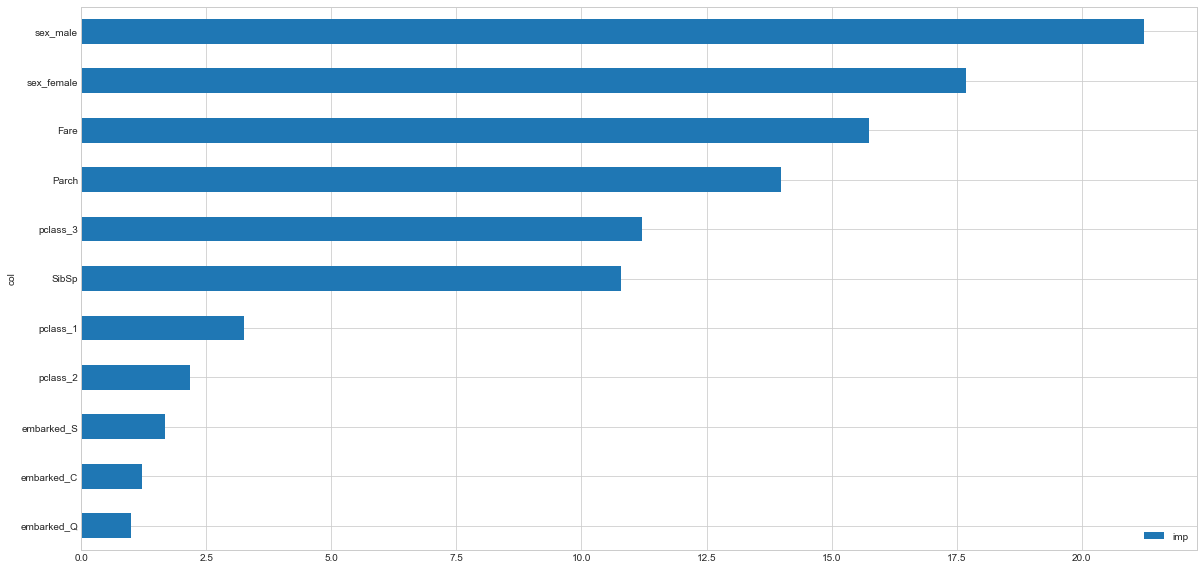

In [103]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

##### Why would you want feature importance?
Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

#### Precision and Recall
Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

Recall = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

Precision = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an F1 score.

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [104]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).


### Submission


Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.
We want to make predictions on the same kind of columnns our model is trained on.
So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model

In [105]:
# We need our test dataframe to look like this one
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [106]:
# Our test dataframe has some columns our model hasn't been trained on
test_dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [107]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test_dataset['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test_dataset['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test_dataset['Pclass'], 
                                   prefix='pclass')

In [108]:
test_plcass_one_hot.head()

,pclass_1,pclass_2,pclass_3
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


In [109]:
test_sex_one_hot.head()

,sex_female,sex_male
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0


In [110]:
test_embarked_one_hot.head()

,embarked_C,embarked_Q,embarked_S
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


In [111]:
# Combine the test one hot encoded columns with test
test = pd.concat([test_dataset, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [112]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


The columns in test have been converted to the same format at df_con_enc. Now we can make predictions on the test dataframe columns we built a model on.

We can find the columns we made predictions on with X_train.columns.

In [113]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [114]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [115]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:300]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], d

In [116]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [117]:
# What does our submission have to look like?
gender_submission_dataset.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


We need our submission dataframe to look like the gender_submisison dataframe, so we'll turn the Survived column into integers

In [118]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [119]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [120]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [121]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../Ajay_catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [122]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../Ajay_catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
